In [0]:
"""Importing all the relevant libraries we need."""

import pandas as pd # For data frames
import numpy as np # For math and efficient arrays
import matplotlib.pyplot as plt # For plotting and visualizing data

# So plots appear in this notebook
%matplotlib inline

In [0]:
""" Grab all the data from github, and read it into dataframes"""

# Get the housing price data
housing_data = pd.read_csv('https://raw.githubusercontent.com/Mvalentino92/JAVA/master/train.csv')

# Print the shape of the data, to see how many instances and features there are
print('There are',housing_data.shape[0],'instances,',housing_data.shape[1]-1,
      'features and of course 1 label.')

There are 1460 instances, 80 features and of course 1 label.


In [0]:
""" Observe how many NaN values there are, and also the features that have NaN values.
    Checking the description.txt file, these NaN values represent the feature not being present.
    For instance, the Alley feature represents the material for access to the home from an Alley.
    It's values can be Pave for pavement, Grvl for gravel, or NaN for representing no Alley access.
    We can check to see if there's any NaN values representing truely missing data.
    By cross checking if NaN's only apppear in the data set in features where the description file
    specifies NaN represents the absence of a feature (Like with Alley)"""

# I want to know how many features contain NaN values
total_nans = 0

# For every feature in the data
for feature in housing_data.columns: 

    # Let's get a boolean vector for if each house in this feature has a NaN value or not.
    # True represents it is NaN, false represents it isnt'
    is_nan = housing_data[feature].isna()

    # If we sum this boolean vector, and we get anything greater than 0, it means there were NaN present.
    nan_sum = np.sum(is_nan)

    # If the sum is greater than 0, print out this feature, and how many NaN's there were (again, the sum)
    # Also, let's add to our running sum.
    if nan_sum > 0:
        print('Feature',feature,'has',nan_sum,'NaN values')
        total_nans = total_nans + 1

# Finally let's print out the running sum
print('\nA total of',total_nans,'features contained at least 1 NaN value.')

Feature LotFrontage has 259 NaN values
Feature Alley has 1369 NaN values
Feature MasVnrType has 8 NaN values
Feature MasVnrArea has 8 NaN values
Feature BsmtQual has 37 NaN values
Feature BsmtCond has 37 NaN values
Feature BsmtExposure has 38 NaN values
Feature BsmtFinType1 has 37 NaN values
Feature BsmtFinType2 has 38 NaN values
Feature Electrical has 1 NaN values
Feature FireplaceQu has 690 NaN values
Feature GarageType has 81 NaN values
Feature GarageYrBlt has 81 NaN values
Feature GarageFinish has 81 NaN values
Feature GarageQual has 81 NaN values
Feature GarageCond has 81 NaN values
Feature PoolQC has 1453 NaN values
Feature Fence has 1179 NaN values
Feature MiscFeature has 1406 NaN values

A total of 19 features contained at least 1 NaN value.


In [0]:
""" Now, let us crosscheck this with the description file,
    to see if we can identify which features have NaNs associated with representing
    the recorded absence of a feature, and which might be associated with truly missing data"""

# I'm going to manually make lists for absence_nan and true_nan
absence_nan = np.array(['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                        'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                        'PoolQC','Fence','MiscFeature'])
true_nan = np.array(['LotFrontage','MasVnrType','MasVnrArea','Electrical','GarageYrBlt'])

# Lets check to make sure the total length of each is 19, confirming we got everything
print(len(absence_nan)+len(true_nan) == 19)

# Now let's make a master list, with all the NaN features, regardless of its context
all_nan = np.append(absence_nan,true_nan)

True


In [0]:
""" Ways for dealing with the NaN values:
    There are two types of features we can deal with.
    1) Numerical
    2) Categorical
    
    These NaN values must be replaced with some actual value. Otherwise Python cannot operate on these.
    For instance if we just wanted to One-Hot encode everything, we would need the NaNs in the categorical features
    to replaced by some actual string. 

    If the objective for some methods for dealing with the NaN's is to replace them, it must be with something meaningful.
    Lets explore some ways below.""" 

# This function will replace the NaN values in supplied features which are numerical with the 
# result of the function you pass it for this feature
# For instance, pass it "np.mean", and it will replace them with the mean.
# The default is mean btw, if you want to change it say to median, do func=np.median
# And for categorical features, will replace the NaN with a string "Missing"
# Also note, this function will actually mutate the dataframe you pass it.
# Because I'm changing information about what the dataframe points to in memory. 
def replace_with_val_or_missing(df,has_nan,func=np.mean):

    # For every featuer in the list
    for feature in has_nan:

        # If the datatype of the feature is object, its categorical
        if np.dtype(df[feature]) == np.dtype('O'):

            # So make the NaN value we're going to fill the feature name plus Missing
            fill_value = 'Missing' 
        
        # Otherwise, the datatype must be numerical
        else:

            # Get indices where it's non nan, to ensure the function works
            not_nan = np.logical_not(np.array(df[feature].isna()))

            # Calculate value to replace by using func, (only on indices where it's NOT NaN!)
            fill_value = func(df[feature][not_nan])

        # Now fill all occurences of NaN with this value (whether is missing or mean)
        df[feature] = df[feature].fillna(fill_value)
    
# A special function to be used with the function above. Simply just returns 0.
# For replacing all the NaNs with 0 if you want!
def just_zero(dummy):
    return 0.0
    
# This function will simply drop all the features from the list of features with NaN
# Keep in mind, this function does not actually mutate (or change) the dataframe passed to it.
# That's why I have to return the new dataframe.
# When you call it, you need to do -> housing_data = drop_nan_features(housing_data,all_nan) for instance.
def drop_nan_features(df,has_nan):

    # One line, pretty easy, thanks Python!
    return df.drop(has_nan,axis=1)

# This function may destroy A LOT of instances, so let's see what happens!
# This will go through the dataframe, and rip out any instances (houses) that contain NaN in any of it's features.
# Note, looking back at how many NaNs appear for each feature, this will immediately take out 1406 instances
# because of the MiscFeature..err feature. So, this should only be used AFTER using another function on some subset
# of features that contain NaN. Maybe after taking care of all features that have A LOT of NaNs.
# Then using this to clean up instances across features with just a "few" (Like all the garage ones for instance)
def drop_nan_instances(df):

    # First we need to get a list of all instances (houses) that have NaN for literally any feature
    # Lets start with an empty list
    nan_indices = np.array([])

    # Now let's begin to iterate the rows of the dataframe, and collect the indices which have NaN's
    for index,house in df.iterrows():

        # Same tactic as before. If the sum is greater than zero this house has NaN values.
        has_nan = np.sum(house.isna()) > 0 

        # If it was true, add this index to the list
        if has_nan:
            nan_indices = np.append(nan_indices,index)
    
    # Now lets drop all this rows! (again have to return the new dataframe, didn't mutate it!)
    return df.drop(nan_indices)

In [0]:
""" EXAAAAAMPLEEEE!!!!!"""
# First I'm going to make a copy of the DataFrame, let's keep "housing_data" as the master one.
data1 = housing_data.copy()

# Lets start by dropping some certain features. Namely the ones that basically have NaN for everything.
# I'll just scroll up, and manually make this list myself.

# These all have over 1000 NaN's just drop them.
big_nan = np.array(['MiscFeature','Fence','Alley','PoolQC'])

# Drop em!
data1 = drop_nan_features(data1,big_nan)

# Alright, now let's replace some NaN's of other features with the median and missing.
# Not all of them though! Namely, I don't want to do this with the Garage ones, I want to rip those rows out at the end.

# Let's get everything minus the Garage ones, and the ones I just did.
# I'm just going to copy and paste and delete stuff, no python magic here, it's manageable
# So I took out 4 + garage ones which is....5 so thats 9. Should have 10 left. Perfect!
replace_nan = np.array(['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                        'FireplaceQu','LotFrontage','MasVnrType','MasVnrArea','Electrical'])

# Replace them!!
replace_with_val_or_missing(data1,replace_nan,func=np.median) 

# Finally, we know that all the NaNs left, have to do with the garage stuff,
# Let's take out instances that are affected, because I want to leave garage in there!
# They all coincidentally have 81 NaN values, perhaps the same ones? So let's just drop those
data1 = drop_nan_instances(data1)

# And lets look at it
data1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Missing,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [0]:
""" Ways for dealing with categorical values
    Here I'm going to implement 3 different ways. 2 of which, I honestly made up.
    They make sense to me, maybe they're "real" anyway! Here are the 3 ways
    1) One hot encoding (will just be using Pythons version)
    2) Proportional assigment (I made this up, will explain)
    3) Rank assigment (I also made this up, but it's basically "smart" integer encoding)

    We need the categorical values to be assigned numeric values for the algorithms to work.
    Using the 3 methods above (or any other methods you guys want to implement!), we can do that."""

# This function will onehot encode the data. It will add more features.
# Maybe this isn't desired, it does make training more computationally expensive.
# Who knows! Try it out!
def onehot(df,label):

    # I'm going to take out the target label, because the function I'm going to use
    # Puts all the onehot encoded things at the end. I still want the label at the end!

    # Copy the label column
    label_col = df[label]

    # Drop it
    df = df.drop(label,axis=1)

    # One hot encode it using pandas function!
    df = pd.get_dummies(df)

    # Add the label column back on the end
    df[label] = label_col

    # Return final dataframe
    return df

""" Okay so here's my custom algorithms. They are almost identical to eachother, besides the value that gets encoded.
    My thought process was the following. 
    First, integer encoding is when you take the categories, and assign an integer value to each.
    For instance, say you had a category for days of the week, and encoded it as Monday = 1, Tuesday = 2 .... Sunday = 7.
    That could potentially give "later days" bias, since they have a larger numerical value.
    It's not like Sunday is 7 times better than Monday ya know?
    There's no meaning to the order assigned, so it introduces bias. 
    What I would like to do, is try to figure out some meaningful ordering between the categories.
    Take the feature Alley for instance. It can have either two values (ignoring NaN stuff)
    Pave and Grvl. (Which stands for pavement or gravel access to home from an alley)
    If I were to take all the houses that have pavement, and get the average SalePrice of those homes
    (Where remember SalePrice is our label to predict), and also do the same for houses that have gravel
    perhaps I can order them meaningfully. If on average houses with pavement seem to have a higher SalePrice assosicated
    with them, then I should assign Pave to a numeric value of 2 (bigger is better!), and Grvl 1.
    Now, I know this is only looking at ONE feature and drawing conclusions about its correlation to SalePrice, but
    I still thought to give it a try. Could not offer insight, since so much goes into contributing to the price 
    (hence this entire problem we're solving!)

    So for proportion ordering, I assign each category a value between 0 and 1. Because whichever category has the largest
    average associated with it, I divide all the others by that. So top dog gets 1, and everyone else (assuming no ties)
    get's a value less than 1, with respect to their closeness to the top dog.

    Rank ordering, is what I described above. If there's 5 categories..
    top dog = 5
    second guy = 4
    .
    .
    .
    last guy = 1"""

# Orders them by proportion!
def orderby_proportion(df,label):

    # Iterate all columns of dataframe
    for col in df.columns:

        # If the type is object, this is a feature we need to covert to numerical!
        if np.dtype(df[col]) == np.dtype('O'):

            # Get all unique categories in this feature
            unique = np.unique(df[col])

            # This computes the averages!
            averages = np.array(list(map(lambda x: df[label][df[col] == x].mean(),unique)))

            # Let's "normalize" the averages by dividing by max average (top dog)
            averages = averages/max(averages)

            # iterate and replace (in place, will mutate!)
            for i in range(0,len(unique)):
                df[col].replace(unique[i],averages[i],inplace=True)

# Orders by an integer ranking! (Basically same code as before)
def orderby_rank(df,label):

    # Iterate all columns of dataframe
    for col in df.columns:

        # If the type is object, this is a feature we need to convert to numerical!
        if np.dtype(df[col]) == np.dtype('O'):

            # Get all unique categories in this feature
            unique = np.unique(df[col])

            # This computes the averages!
            averages = np.array(list(map(lambda x: df[label][df[col] == x].mean(),unique)))

            # This will return a list of indices for sorting this array in non-descending order (smallest to largest)
            sorted_indices = np.argsort(averages)

            # iterate and replace (in place, will mutate!)
            for i in range(0,len(unique)):

                # This is assiging the proper ranks. Starting with 1 and going to n, for n categories.
                df[col].replace(unique[sorted_indices[i]],i+1,inplace=True)

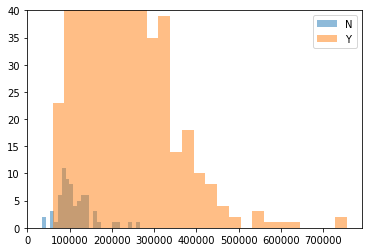

In [0]:
""" CONTINUED EXAMPLEEEEEE"""

# Alright, let's take our data1 and order by rank! 

# First lets make sure it's actually correct!
# Let's a make some histograms of the categories from CentralAir, to see if there's a clear ranking among the averages
# So we can double check with our results
# I would assume houses with CentralAir would be worth more!
feature = 'CentralAir'
categories = np.unique(data1[feature])
for category in categories:
    plt.hist(data1['SalePrice'][data1[feature] == category],alpha=0.5,bins=25)
    plt.ylim((0,40))
    plt.legend(categories)

# So I got the top off a little, but it seems clear that houses with CentralAir have a higher average.
# Lets encode it by rank, and replot, we should see N as 1 and Y as 2!

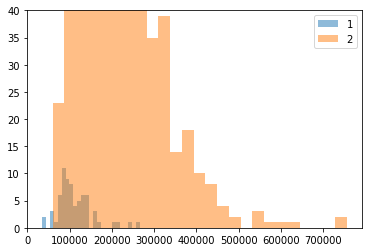

In [0]:
# Making a copy
data1_cpy = data1.copy()
orderby_rank(data1_cpy,'SalePrice')
feature = 'CentralAir'
categories = np.unique(data1_cpy[feature])
for category in categories:
    plt.hist(data1_cpy['SalePrice'][data1_cpy[feature] == category],alpha=0.5,bins=25)
    plt.ylim((0,40))
    plt.legend(categories)

# Cool, we see 1 then 2!

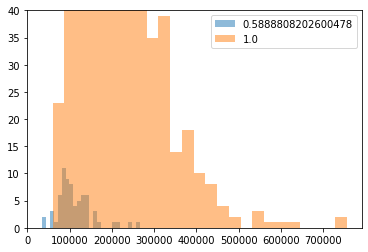

In [0]:
# Okay, lets try it by proportion!
# Making a copy
data1_cpy = data1.copy()
orderby_proportion(data1_cpy,'SalePrice')
feature = 'CentralAir'
categories = np.unique(data1_cpy[feature])
for category in categories:
    plt.hist(data1_cpy['SalePrice'][data1_cpy[feature] == category],alpha=0.5,bins=25)
    plt.ylim((0,40))
    plt.legend(categories)

# Alright, so Y gets 1.0, and N got about half that.

In [0]:
""" Alright, so here I'm going to show an example, of doing Linear Regression using Pythons libraries
    and the functions I wrote above. From start to end.

    There's a few more things to show, so I will and will describe them as I'm doing them
    Let's begin!"""

# First, let's make a copy of the master data.
df = housing_data.copy()

# Update, I'm taking out any houses that make over 400,000
df = df[df['SalePrice'] < 400000]

# Now, I'm going to use the functions for dealing with NaNs again. 
# I actually did like what I did before with the example, so I will do that again.
# (Same code as my example before, minus the comments)
big_nan = np.array(['MiscFeature','Fence','Alley','PoolQC'])
df = drop_nan_features(df,big_nan)
replace_nan = np.array(['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                        'FireplaceQu','LotFrontage','MasVnrType','MasVnrArea','Electrical'])
replace_with_val_or_missing(df,replace_nan,func=np.median) 
df = drop_nan_instances(df)

# Now that all the NaN's have been taken care of, I'm going to encode the categorical using the rank ordering.
orderby_rank(df,'SalePrice')

# Let me show the new data now, and somewhat confirm it looks correct.
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,4,65.0,8450,2,1,2,2,1,1,17,5,5,4,8,7,5,2003,2003,2,3,11,14,3,196.0,3,3,6,4,4,2,7,706,5,0,150,856,6,5,2,6,856,854,0,1710,1,0,2,1,3,1,3,8,7,0,2,5,2003.0,2,2,548,4,5,3,0,61,0,0,0,0,0,2,2008,6,5,208500
1,2,20,4,80.0,9600,2,1,2,2,3,1,21,3,5,4,6,6,8,1976,1976,2,3,5,4,2,0.0,2,3,3,4,4,5,5,978,5,0,284,1262,6,5,2,6,1262,0,0,1262,0,1,2,0,3,1,2,6,7,1,4,5,1976.0,2,2,460,4,5,3,298,0,0,0,0,0,0,5,2007,6,5,181500
2,3,60,4,68.0,11250,2,2,2,2,1,1,17,5,5,4,8,7,5,2001,2002,2,3,11,14,3,162.0,3,3,6,4,4,3,7,486,5,0,434,920,6,5,2,6,920,866,0,1786,1,0,2,1,3,1,3,6,7,1,4,5,2001.0,2,2,608,4,5,3,0,42,0,0,0,0,0,9,2008,6,5,223500
3,4,70,4,60.0,9550,2,2,2,2,2,1,18,5,5,4,8,7,5,1915,1970,2,3,4,7,2,0.0,2,3,2,3,5,2,5,216,5,0,540,756,6,4,2,6,961,756,0,1717,1,0,1,0,3,1,3,7,7,1,5,2,1998.0,1,3,642,4,5,3,0,35,272,0,0,0,0,2,2006,6,2,140000
4,5,60,4,84.0,14260,2,2,2,2,3,1,25,5,5,4,8,8,5,2000,2000,2,3,11,14,3,350.0,3,3,6,4,4,4,7,655,5,0,490,1145,6,5,2,6,1145,1053,0,2198,1,0,2,1,4,1,3,9,7,1,4,5,2000.0,2,3,836,4,5,3,192,84,0,0,0,0,0,12,2008,6,5,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,4,62.0,7917,2,1,2,2,1,1,15,5,5,4,8,6,5,1999,2000,2,3,11,14,2,0.0,2,3,6,4,4,2,6,0,5,0,953,953,6,5,2,6,953,694,0,1647,0,0,2,1,3,1,2,7,7,1,4,5,1999.0,2,2,460,4,5,3,0,40,0,0,0,0,0,8,2007,6,5,175000
1456,1457,20,4,85.0,13175,2,1,2,2,1,1,14,5,5,4,6,6,6,1978,1988,2,3,9,11,5,119.0,2,3,3,4,4,2,5,790,3,163,589,1542,6,3,2,6,2073,0,0,2073,1,0,2,0,3,1,2,7,3,2,4,5,1978.0,1,2,500,4,5,3,349,0,0,0,0,0,0,2,2010,6,5,210000
1457,1458,70,4,66.0,9042,2,1,2,2,1,1,18,5,5,4,8,7,9,1941,2006,2,3,12,15,2,0.0,4,2,4,3,5,2,7,275,5,0,877,1152,6,5,2,6,1188,1152,0,2340,0,0,2,0,4,1,3,9,7,2,5,5,1941.0,2,1,252,4,5,3,0,60,0,0,0,0,2500,5,2010,6,5,266500
1458,1459,20,4,68.0,9717,2,1,2,2,1,1,11,5,5,4,6,5,6,1950,1996,5,3,5,4,2,0.0,2,3,3,3,4,3,7,49,3,1029,0,1078,6,4,2,4,1078,0,0,1078,1,0,1,0,2,1,3,5,7,0,2,5,1950.0,1,1,240,4,5,3,366,0,112,0,0,0,0,4,2010,6,5,142125


In [0]:
# Okay looks good, so now I need to do two things.
# 1) I need to convert everything to matrices so pythons function can work on them
# 2) I need to split train and test data.
# One observation I'm making though, is that the first feature is just the ID.
# It's literally just numerical order of the houses. I don't actually want to include this, so I will omit it from the matrix.

# Let's grab the feature column out of the data, and convert to a vector
labels = np.array(df['SalePrice'])

# Now lets grab all the features, except the first and the last (first being ID, last being SalePrice)
# Note python is (inclusive,exclusive), so [1:-1], will grab everything from 1 up (not index 0), up to 
# the second to last index ,(because -1 represents the last index)
features = np.array(df[df.columns[1:-1]])

# Okay great, now we're going to use one of sklearns functions to split into train and test data
# The test_size = 0.20, means i want 4/5 for training and 1/5 for test
from sklearn.model_selection import train_test_split
train_features,test_features,train_labels,test_labels = train_test_split(features,labels,test_size=0.20)

In [0]:
# Alright, now it's time to train the Linear Regression model, this part is easy!

# Lets import the LinearRegression
from sklearn.linear_model import LinearRegression

# Let's create a Linear Regression model (That's "empty" for now)
reg = LinearRegression()

# Let's use it's fit function, to train it on our data
reg.fit(train_features,train_labels)

# Let's get our predictions for the test data
predictions = reg.predict(test_features)

In [0]:
# Alright, we have our predictions!
# Let's use a few different metrics to measure the accuracy

# Using some of sklearns metrics
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions))

# And manually write mean absolute percentage error
mean_abs_per_err = np.sum(np.abs(predictions - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

Mean absolute error is: 18040.394352528372
Mean squared log error is: 0.027897831162874653
Mean absolute percent error is: 11.05214636022995


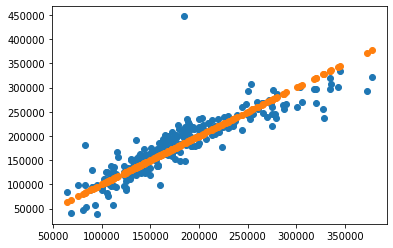

In [0]:
# Okay, not terrible I guess? I haven't done it against something else so I would know!
# Let's plot the predictions versus the actual
# As well at the actual versus the actual (to see how our predictions differ)
plt.scatter(test_labels,predictions)
plt.scatter(test_labels,test_labels)

# Okay so for every predictions, if it's less than the actual, it will be below the orange line
# And if it's greater than the actual, it will be above it. 

# For lower priced houses it seems ot be pretty even between undershooting and overshooting,
# Buta s the houses get pricey ,it always undershoots, drastically. 
# Granted there's not many pricier houses. 

# I'll try one more thing below. I'll use Polynomial features.

In [0]:
# Alright, let's update the data to use polynomial features

# Lets create the Polynomial Feature object, with degree 2.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

# Let's fit and transform the train and test features
train_features_poly = poly.fit_transform(train_features)
test_features_poly = poly.fit_transform(test_features)

# Let's check out the shapes now
print(train_features_poly.shape)
print(test_features_poly.shape)

# Perfect

(1080, 2926)
(271, 2926)


In [0]:
# Now we have to train another Linear Regression Model, using the updated feature matrices
reg_poly = LinearRegression()
reg_poly.fit(train_features_poly,train_labels)
predictions_poly = reg_poly.predict(test_features_poly)

# Let's print coefficient sum
print(np.sum(np.abs(reg_poly.coef_)))

299469.504796421


Mean absolute error is: 198176.20481141424
Mean absolute percent error is: 120.17374875537247


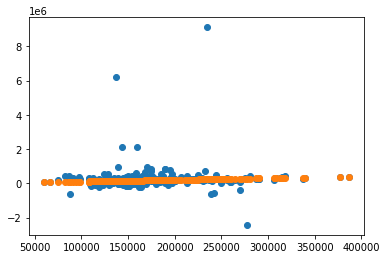

In [0]:
# Alright same deal as before, let's look at the error and some plots

import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_poly))
#print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_poly))

mean_abs_per_err = np.sum(np.abs(predictions_poly - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_poly)
plt.scatter(test_labels,test_labels)

# Wow it's terrible. I couldn't even do the mean squared log error becaues of negative values predicted for houses!
# Let's use Ridge Regression instead and hope the normalization get's this under control

In [0]:
from sklearn.linear_model import Ridge

# Alpha has to be this big before we don't get negative values anymore! (Alpha is the penalty)
ridge = Ridge(alpha=10000000)

# Fit it
ridge.fit(train_features_poly,train_labels)

# Predictions
predictions_ridge = ridge.predict(test_features_poly)

# Let's print the sum of the coefficients out
print(np.sum(np.abs(ridge.coef_)))

1163.4737703893911


Mean absolute error is: 22672.742739274185
Mean absolute percent error is: 13.074538003000976


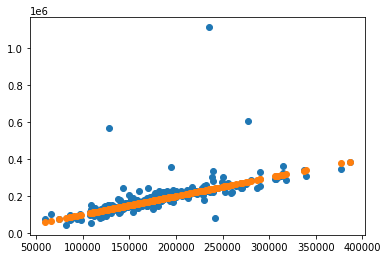

In [0]:
# Alright same deal as before, let's look at the error and some plots

import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_ridge))
#print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_ridge))

mean_abs_per_err = np.sum(np.abs(predictions_ridge - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_ridge)
plt.scatter(test_labels,test_labels)

# Wow look how fare off the one guy is!
# Okay, let's try one more thing. With this simple models. 
# I'm going to scale the data first.
# Because well.. look at the description (next cell)

In [0]:
df.describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000
mean,733.213175,56.232420,3.870466,69.954848,10536.843819,1.996299,1.428571,2.052554,1.999260,1.661732,1.062176,13.175426,4.802369,4.987417,4.706144,5.815692,6.126573,5.584752,1972.414508,1985.053294,2.600296,4.024426,8.092524,9.459660,2.576610,100.649149,2.399704,2.874167,4.232420,3.519615,3.970392,2.619541,5.232420,441.890452,4.766099,48.566987,565.410067,1055.867506,5.963731,4.157661,1.948927,5.820873,1160.649889,344.109548,3.797187,1508.556625,0.424130,0.059215,1.564767,0.387121,2.858623,1.039230,2.521095,6.487047,6.790526,0.627683,3.313101,4.151739,1977.997039,1.798668,1.848261,494.057735,2.973353,4.891932,2.893412,95.358253,46.104367,21.082902,3.684678,15.444115,2.570688,43.777942,6.348631,2007.813472,5.210955,4.897113,179163.629904
std,421.738807,41.327715,0.512316,21.536984,10156.350758,0.060745,0.644554,0.444946,0.027206,1.171391,0.275919,6.221077,1.002306,0.256452,0.798303,1.360585,1.286211,1.084588,29.275370,20.466091,1.204362,0.293376,2.883341,3.716385,0.895181,170.269246,0.551201,0.373778,1.641368,0.759742,0.409892,1.048613,1.744626,444.814328,0.873515,165.307228,437.935990,415.563651,0.316489,0.951964,0.220229,0.630492,368.849755,428.034412,37.477187,482.784431,0.513502,0.239231,0.537541,0.500767,0.778411,0.197991,0.631957,1.525954,0.838746,0.641598,1.349501,1.431884,24.672612,0.807941,0.615776,180.499393,0.245011,0.563206,0.425703,125.288918,64.457901,60.447288,30.461265,56.086412,38.961529,506.750734,2.696334,1.329159,1.243912,0.691053,64939.223892
min,1.000000,20.000000,1.000000,21.000000,1300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1880.000000,1950.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,438.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,160.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1.000000,1.000000,35311.000000
25%,366.500000,20.000000,4.00000

In [0]:
# Some of the features range of numbers values A LOT. Just look at the means. 
# Lets use a Standard Scaler to sort of normalize these values and get them closer together.
# This may help the algorithms more accurately predict.

from sklearn.preprocessing import StandardScaler

# Lets Scale both train and test data
scaler = StandardScaler()
scaler.fit(train_features_poly)
train_features_poly_scaled = scaler.transform(train_features_poly)
test_features_poly_scaled = scaler.transform(test_features_poly)

# Let describe again below

In [0]:
pd.DataFrame(train_features_scaled).describe()

# Cool, they are pretty small values, but at least all the same. Let's see how it works.
# I'll use ridge regression again below

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
count,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1080.0,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03,1.080000e+03
mean,8.719877e-17,1.587208e-16,2.841349e-16,-7.646597e-17,-9.256998e-16,-5.220104e-16,-8.158340e-17,0.0,-1.258253e-16,-5.175901e-17,1.455626e-16,2.620332e-16,5.607654e-16,2.076528e-17,-2.426043e-16,-2.113536e-16,4.857740e-16,-2.765689e-15,4.826797e-15,1.068076e-16,2.716191e-16,-4.066706e-16,-3.900172e-16,2.031297e-16,1.064992e-16,-5.900630e-16,1.574872e-16,-1.739349e-16,4.428556e-16,1.211736e-17,3.246374e-16,1.735237e-16,1.315820e-17,7.117763e-16,1.515249e-16,-2.426043e-17,1.700286e-16,-1.258690e-15,4.050258e-17,1.731126e-16,3.898116e-16,2.077556e-16,3.166192e-17,7.547975e-17,-2.165449e-16,8.223874e-17,4.975444e-17,-2.919475e-17,1.017704e-16,-1.903056e-16,5.460653e-16,-1.334324e-16,-5.242720e-18,2.806397e-17,-1.460766e-16,1.748601e-16,2.152599e-16,-3.362331e-15,6.188465e-17,-1.130783e-18,-1.459224e-16,-5.448317e-17,-1.646317e-16,2.597716e-16,-9.231299e-17,1.027984e-18,2.432725e-16,1.246688e-16,2.451743e-16,7.923189e-17,1.971931e-16,-2.171103e-16,-3.703509e-14,3.322445e-16,-1.056768e-16
std,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,0.0,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00,1.000463e+00
min,-8.748885e-01,-5.486878e+00,-2.391375e+00,-9.137171e-01,-1.466288e+01,-6.950044e-01,-2.316884e+00,0.0,-5.166622e-01,-2.274456e-01,-1.934881e+00,-3.816519e+00,-1.390011e+01,-4.541048e+00,-3.025636e+00,-3.212072e+00,-3.291449e+00,-3.090918e+00,-1.721538e+00,-1.328225e+00,-5.392978e+00,-2.116357e+00,-2.153176e+00,-1.754791e+00,-5.826789e-01,-2.513889e+00,-4.909532e+00,-1.948631e+00,-3.286809e+00,-7.280662e+00,-1.529184e+00,-2.449203e+00,-9.774048e-01,-4.321610e+00,-2.860896e-01,-1.313294e+00,-2.493385e+00,-1.579822e+01,-2.284593e+00,-4.236433e+00,-7.817650e+00,-1.915966e+00,-8.073557e-01,-1.057773e-01,-2.175707e+00,-8.212498e-01,-2.530601e-01,-2.928085e+00,-7.705290e-01,-3.656715e+00,-2.062884e-01,-2.404357e+00,-2.254029e+00,-6.815968e+00,-9.776790e-01,-1.720348e+00,-2.182002e+00,-3.136496e+00,-9.875066e-01,-1.378946e+00,-1.8

349051.41281673504
Mean absolute error is: 13549.134848405469
Mean squared log error is: 0.011781048922355802
Mean absolute percent error is: 8.300366538736686


'Mean absolute error is: 15553.590488903548\nMean squared log error is: 0.012423240397879879\nMean absolute percent error is: 8.760501707797715'

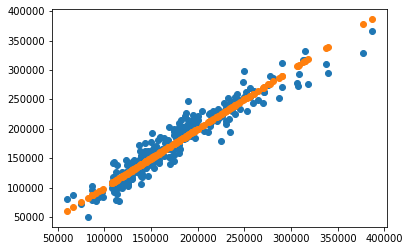

In [0]:
# Alpha at 1000 gives pretty good results!
ridge = Ridge(alpha=1000)

# Fit it
ridge.fit(train_features_poly_scaled,train_labels)

# Predictions
predictions_ridge = ridge.predict(test_features_poly_scaled)

# Let's print the sum of the coefficients out
print(np.sum(np.abs(ridge.coef_)))


import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_ridge))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_ridge))

mean_abs_per_err = np.sum(np.abs(predictions_ridge - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_ridge)
plt.scatter(test_labels,test_labels)

# So in total, we were able to go from a Simple Linear Regresssion with the following errors
"""Mean absolute error is: 18359.432991406793
Mean squared log error is: 0.02077085052753611
Mean absolute percent error is: 10.806407199535757"""

# To a Scaled Regularized Polynomial Regression with the following errors
"""Mean absolute error is: 15553.590488903548
Mean squared log error is: 0.012423240397879879
Mean absolute percent error is: 8.760501707797715"""

# Not that much better, but had a very small improvement. Although, the alpha penalty had to be pretty high!
# So maybe this data is more or less linear.
# Again, I prepped it a specific way. Perhaps keeping all the features, or onehot encoding, 
# dealing with the NaNs a different way ect would fair better.

In [0]:
""" Here I will now define a few functions to perform gradient boosting with two different predictors.
    The one that gradient boosting is apparently done with commonly (and intended for), which is decision trees.
    But also, I want to see if Linear Regression will benefit from it. I really don't know. How gradient boosting is set
    up, I'm not sure what will happen with Linear Regressino. You get an ensemble of predictors, all with there own
    set of thetas for the data. And you predict for each and add up all the predictions. 
    So really all your getting with Linear Regression is some new set of theta's
    since you can add like terms. But let's see what happens! Also, lets mix it up and allow this function 
    to do gradient boosting with both linear regression and decision trees!!!"""
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# This function will return an array of predictors
def gboost(X,y,predictor="dt",subsample=True,subsample_size=0.65,size=10,maxdepth=None,minsamplesleaf=1):

    # Just something I need for later
    l = len(y)
    subindices = np.arange(0,l)

    # The array of predictors to be returned
    ps = np.empty(size,dtype=object)

    # Begin to generate the predictors
    for i in range(0,size):

        # Find which predictor to use
        p = None
        if predictor == "dt":
            p = DecisionTreeRegressor(max_depth=maxdepth,min_samples_leaf=minsamplesleaf)
        elif predictor == "reg":
            p = LinearRegression()
        else:
            if i % 2 == 0:
                p = DecisionTreeRegressor(max_depth=maxdepth,min_samples_leaf=minsamplesleaf)
            else:
                p = LinearRegression()
            
        # If subsample is true, take a random subsample of X for training
        if subsample:
            subindices = np.random.choice(X.shape[0],size=int(subsample_size*l))
            
        # Train the regressor
        p.fit(X[subindices],y[subindices])

        # Get new y for next iteration (predicting on entire training set)
        y = y - p.predict(X)

        # Add this predictor to the final list
        ps[i] = p
        
    return ps

# Will evaluate, with an optional decay constant
def boostpredict(X,predictors,decay=1):
    alpha = 1
    yhat = np.zeros(X.shape[0])
    
    for p in predictors:
        yhat = yhat + alpha*p.predict(X)
        alpha = alpha * decay
    
    return yhat

In [0]:
# Here's another example, let's build a couple gradient boosters. I want to scale the data first
from sklearn.preprocessing import StandardScaler

# Lets Scale both train and test data (with the standard scaler from the train data)
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [0]:
# Now lets get our list of predictors back
ps = gboost(train_features_scaled,train_labels,predictor="reg",size=8,subsample_size=0.75,maxdepth=2,minsamplesleaf=0.15)

Mean absolute error is: 18446.949620717176
Mean squared log error is: 0.023891289221882415
Mean absolute percent error is: 11.041033198580926


(0.0, 500000.0)

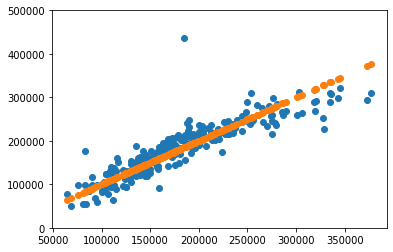

In [0]:
# Lets get our predictions by summing up
predictions = boostpredict(test_features_scaled,ps,decay=0.95)

# Do the usual error analysis
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions))

mean_abs_per_err = np.sum(np.abs(predictions - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions)
plt.scatter(test_labels,test_labels)
plt.ylim((0,500000))

In [0]:
import sklearn.metrics as met

def score(X,y,x):

    # Get mse for every instance in X against x, and put everything over 1
    mse = (1 / np.array(list(map(lambda k: met.mean_squared_error(x,k),X))))**2

    # Get proportions
    mse = mse / np.sum(mse)

    # return value
    return np.sum(mse*y)

def test(X,y,Xprime):

    # just map this over entire Xprime
    return np.array(list(map(lambda x: score(X,y,x),Xprime)))

In [0]:
predictions = test(train_features,train_labels,test_features)

Mean absolute error is: 27536.249582565488
Mean squared log error is: 0.04580225501846436
Mean absolute percent error is: 16.39905942845474


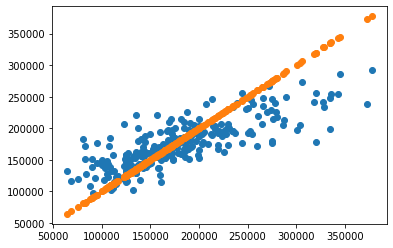

In [0]:
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions))

mean_abs_per_err = np.sum(np.abs(predictions - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions)
plt.scatter(test_labels,test_labels)

In [0]:
# Okay, time to do a Random Forest. The data doesn't need to be scaled for them.
from sklearn.ensemble import RandomForestRegressor

# I want 256 DecisionTrees in the forest.
# We can also pass any attributes we want for each decision tree in the forest. 
rf = RandomForestRegressor(n_estimators=256)

# Let's fit the data.
rf.fit(train_features,train_labels)

# Get predictions
predictions_forest = rf.predict(test_features)

Mean absolute error is: 14654.536900369003
Mean squared log error is: 0.014989275877714097
Mean absolute percent error is: 8.631041094793003


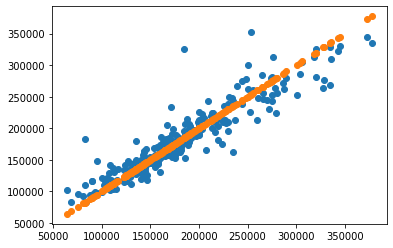

In [0]:
# Usual
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_forest))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_forest))

mean_abs_per_err = np.sum(np.abs(predictions_forest - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_forest)
plt.scatter(test_labels,test_labels)

# Not bad at all.

In [0]:
# Alright let's try Pythons built in gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

# Try with some default parameters
bst = GradientBoostingRegressor(subsample=0.9,learning_rate=0.05,n_estimators=1024)

# Train it
bst.fit(train_features,train_labels)

# Get predictions
predictions_boost = bst.predict(test_features)

Mean absolute error is: 13957.340267858717
Mean squared log error is: 0.014497842903561015
Mean absolute percent error is: 8.318221122109893


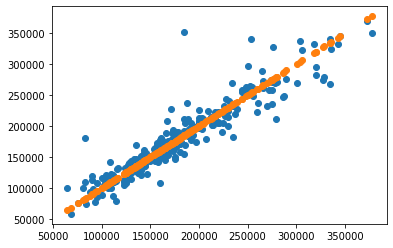

In [0]:
# Usual
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_boost))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_boost))

mean_abs_per_err = np.sum(np.abs(predictions_boost - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_boost)
plt.scatter(test_labels,test_labels)

# Hey pretty good!

In [0]:
# Alright, let's finally do neural network!!!

import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(8,activation='relu'))
model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(2,activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_features_scaled,train_labels,epochs=1024,verbose=0)
predictions_nn = model.predict(test_features_scaled)

Mean absolute error is: 21366.64934559502
Mean squared log error is: 0.02982237750229536
Mean absolute percent error is: 13.005447963324437


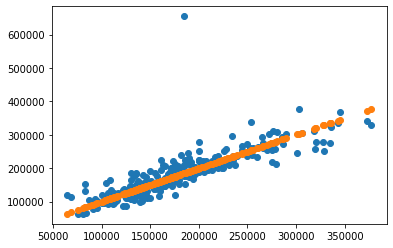

In [0]:
# Usual
import sklearn.metrics as met
print('Mean absolute error is:',met.mean_absolute_error(test_labels,predictions_nn))
print('Mean squared log error is:',met.mean_squared_log_error(test_labels,predictions_nn))

mean_abs_per_err = np.sum(np.abs(predictions_nn.T - test_labels)/test_labels)/len(test_labels)*100
print('Mean absolute percent error is:',mean_abs_per_err)

plt.scatter(test_labels,predictions_nn)
plt.scatter(test_labels,test_labels)